In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import re

C1true = 1.0
C2true = 0.01

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# load the training data

def load_training_data (num):
    data = loadmat("cylinder_nektar_wake.mat")
    #print(data)
    
    U_star = data["U_star"] #N X 2 X T
    P_star = data["p_star"] #N X T
    t_star = data["t"]  # T
    X_star = data["X_star"] # N X 2
    
    #print("X_star.shape",X_star.shape)
    #print("X_star",X_star)
    
    N = X_star.shape[0]
    T = t_star.shape[0]
    
    XX = np.tile(X_star[:,0:1], (1,T))
    YY = np.tile(X_star[:,1:2], (1,T))
    TT = np.tile(t_star, (1,N)).T
    UU = U_star[:, 0, :]
    VV = U_star[:, 1, :]
    PP = P_star
    
    #print("VVshape",VV.shape)
    #print("VV",VV)
    
    x = XX.flatten()[:,None]  # NT x 1
    y = YY.flatten()[:,None]
    t = TT.flatten()[:,None]
    u = UU.flatten()[:,None]
    v = VV.flatten()[:,None]
    p = PP.flatten()[:,None]
    
    #print("t.shape",t.shape)
    #print("t",t)
    
    data1 = np.concatenate([x, y, t, u, v, p], 1)
    
    #print("data1.shape",data1.shape)
    #print("data1",data1)
    
    # X xY = [1,8] x [-2, 2],  time = [0,7]
    
    data2 = data1[:,:][data1[:,2] <= 7]
    data3 = data2[:,:][data2[:,0] >= 1]
    data4 = data3[:,:][data3[:,0] <= 8]
    data5 = data4[:,:][data4[:,1] >= -2]
    data6 = data5[:,:][data5[:,1] <= 2]
    
    data_domian = data6
    
    #print("data_domian.shape",data_domian.shape)
    #print("data_domian",data_domian)
    
    idx = np.random.choice(data_domian.shape[0], num, replace= False)
    
    #print("idx",idx)
    
    x_train = data_domian[idx, 0:1]
    y_train = data_domian[idx, 1:2]
    t_train = data_domian[idx, 2:3]
    u_train = data_domian[idx, 3:4]
    v_train = data_domian[idx, 4:5]
    p_train = data_domian[idx, 5:6]
    
    return [x_train, y_train, t_train, u_train, v_train, p_train]

In [3]:
[ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num = 7000)

print("ob_y.shape",ob_y.shape)
print("ob_y",ob_y)

ob_xyt = np.hstack((ob_x,ob_y,ob_t))


print("ob_xyt.shape",ob_xyt.shape)
print("ob_xyt",ob_xyt)

ob_y.shape (7000, 1)
ob_y [[-1.10204082]
 [ 0.85714286]
 [-0.93877551]
 ...
 [ 1.10204082]
 [-1.59183673]
 [ 0.6122449 ]]
ob_xyt.shape (7000, 3)
ob_xyt [[ 4.04040404 -1.10204082  1.9       ]
 [ 1.84848485  0.85714286  3.7       ]
 [ 3.61616162 -0.93877551  3.1       ]
 ...
 [ 2.62626263  1.10204082  2.3       ]
 [ 5.66666667 -1.59183673  3.4       ]
 [ 6.51515152  0.6122449   1.        ]]


In [4]:
C1 = dde.Variable(0.0)
C2 = dde.Variable(0.0)

In [5]:
def Navier_Stokes_Equation(x,y):
    u = y[:, 0:1]
    v = y[:, 1:2]
    p = y[:, 2:3]
    
    
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    du_t = dde.grad.jacobian(y, x, i=0, j=2)
    
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dv_t = dde.grad.jacobian(y, x, i=1, j=2)
    
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)
    
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    
    dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    
    continuity = du_x + dv_y
    x_momentum = du_t + C1 * (u * du_x + v * du_y) + dp_x - C2 * (du_xx + du_yy)
    y_momentum = dv_t + C1 * (u * dv_x + v * dv_y) + dp_y - C2 * (dv_xx + dv_yy)
    
    return [continuity, x_momentum, y_momentum]

In [6]:
# define the DNN
layer_size = [3] + [50]*6 + [3]
activation = "tanh"
intializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, intializer)

In [7]:
Lx_min, Lx_max = 1.0, 8.0
Ly_min, Ly_max = -2.0, 2.0

space_domain = dde.geometry.Rectangle([Lx_min,Ly_min],[Lx_max,Ly_max])

time_domain =dde.geometry.TimeDomain(0,7)

geomtime =dde.geometry.GeometryXTime(space_domain,time_domain)

In [8]:
obsevrve_u = dde.icbc.PointSetBC(ob_xyt,ob_u, component=0)
obsevrve_v = dde.icbc.PointSetBC(ob_xyt,ob_v, component=1)
obsevrve_p = dde.icbc.PointSetBC(ob_xyt,ob_p, component=2)

In [9]:
# Training dataset used to calculate the loss
data = dde.data.TimePDE(geomtime,
                        Navier_Stokes_Equation,
                        [obsevrve_u, obsevrve_v, obsevrve_p],
                       num_domain = 700,
                       num_boundary=200,
                       num_initial=100,
                       anchors= ob_xyt)

Compiling model...
'compile' took 0.003403 s

Training model...



C:\Users\mecha\anaconda3\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Step      Train loss                                                      Test loss                                                       Test metric
0         [1.45e-02, 1.51e-02, 2.32e-03, 1.51e-01, 1.27e-01, 1.33e-02]    [1.45e-02, 1.51e-02, 2.32e-03, 1.51e-01, 1.27e-01, 1.33e-02]    []  
1000      [7.90e-04, 9.75e-04, 8.11e-04, 2.86e-03, 3.88e-03, 7.20e-04]    [7.90e-04, 9.75e-04, 8.11e-04, 2.86e-03, 3.88e-03, 7.20e-04]    []  
2000      [2.48e-04, 5.06e-04, 5.06e-04, 1.17e-03, 1.75e-03, 2.64e-04]    [2.48e-04, 5.06e-04, 5.06e-04, 1.17e-03, 1.75e-03, 2.64e-04]    []  
3000      [2.75e-04, 4.07e-04, 3.86e-04, 8.46e-04, 1.39e-03, 1.74e-04]    [2.75e-04, 4.07e-04, 3.86e-04, 8.46e-04, 1.39e-03, 1.74e-04]    []  
4000      [2.90e-04, 3.33e-04, 3.11e-04, 6.37e-04, 1.05e-03, 1.25e-04]    [2.90e-04, 3.33e-04, 3.11e-04, 6.37e-04, 1.05e-03, 1.25e-04]    []  
5000      [1.40e-04, 2.17e-04, 2.08e-04, 4.41e-04, 6.55e-04, 6.64e-05]    [1.40e-04, 2.17e-04, 2.08e-04, 4.41e-04, 6.55e-04, 6.64e-05] 

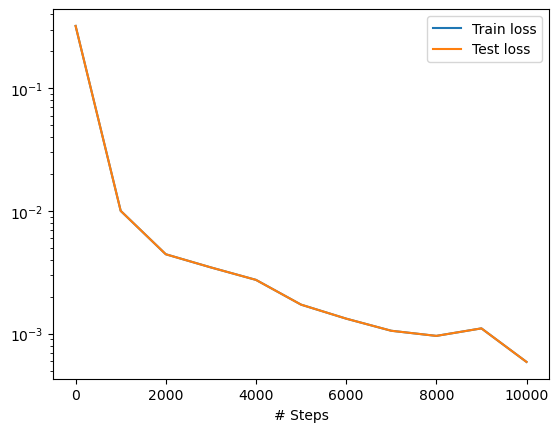

Compiling model...
'compile' took 0.037308 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
10000     [7.32e-05, 9.95e-05, 8.79e-05, 1.38e-04, 1.72e-04, 1.90e-05]    [7.32e-05, 9.95e-05, 8.79e-05, 1.38e-04, 1.72e-04, 1.90e-05]    []  
11000     [6.55e-05, 8.92e-05, 7.63e-05, 1.24e-04, 1.37e-04, 1.54e-05]    [6.55e-05, 8.92e-05, 7.63e-05, 1.24e-04, 1.37e-04, 1.54e-05]    []  
12000     [5.65e-05, 7.85e-05, 6.63e-05, 1.05e-04, 1.09e-04, 1.33e-05]    [5.65e-05, 7.85e-05, 6.63e-05, 1.05e-04, 1.09e-04, 1.33e-05]    []  
13000     [4.93e-05, 7.00e-05, 5.91e-05, 9.15e-05, 8.92e-05, 1.16e-05]    [4.93e-05, 7.00e-05, 5.91e-05, 9.15e-05, 8.92e-05, 1.16e-05]    []  
14000     [4.43e-05, 6.31e-05, 5.39e-05, 8.59e-05, 7.61e-05, 1.04e-05]    [4.43e-05, 6.31e-05, 5.39e-05, 8.59e-05, 7.61e-05, 1.04e-05]    []  
15000     [3.87e-05, 5.67e-05, 4.88e-05, 7.27e-05, 6.59e-05, 9.34e-06]

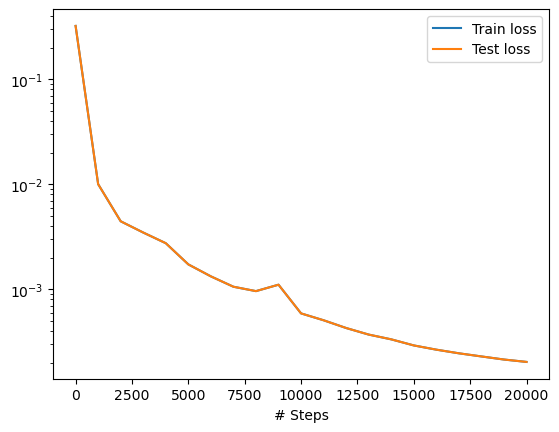

Mean residual: 0.004192664


In [10]:
model = dde.Model(data, net)

results_file_C1_C2 = "variables_main_C1_C2.dat"
variable = dde.callbacks.VariableValue([C1,C2], period = 100, filename= results_file_C1_C2)

model.compile("adam", lr=1e-3, external_trainable_variables=[C1,C2])
loss_history, train_state= model.train(iterations=10000, callbacks=[variable],display_every=1000,disregard_previous_best= True)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)


model.compile("adam", lr=1e-4, external_trainable_variables=[C1,C2])
loss_history, train_state= model.train(iterations=10000, callbacks=[variable],display_every=1000,disregard_previous_best= True)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)


f= model.predict(ob_xyt, operator= Navier_Stokes_Equation)
print("Mean residual:", np.mean(np.absolute(f)))

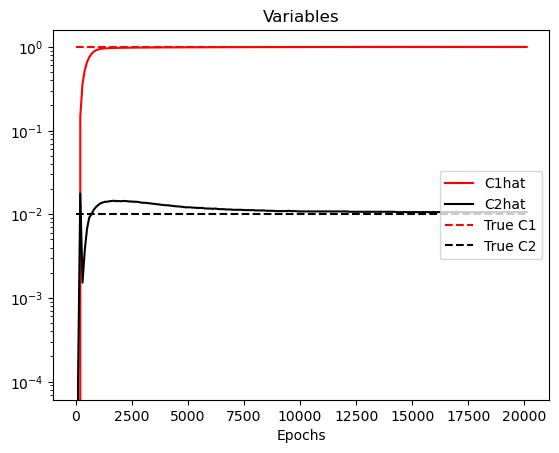

In [11]:
# Plot Variables:
# reopen saved data using callbacks in results_file_C1_C2

results_file_C1_C2 = "variables_main_C1_C2.dat"
lines = open(results_file_C1_C2, "r").readlines()
# read output data in fnamevar
Chat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
l, c = Chat.shape
plt.semilogy(range(0, l * 100, 100), Chat[:, 0], "r-")
plt.semilogy(range(0, l * 100, 100), Chat[:, 1], "k-")
plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 0].shape) * C1true, "r--")
plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 1].shape) * C2true, "k--")
plt.legend(["C1hat", "C2hat", "True C1", "True C2"], loc="right")
plt.xlabel("Epochs")
plt.title("Variables")
plt.show()

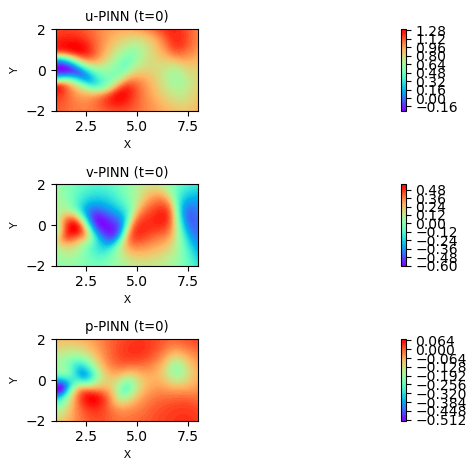

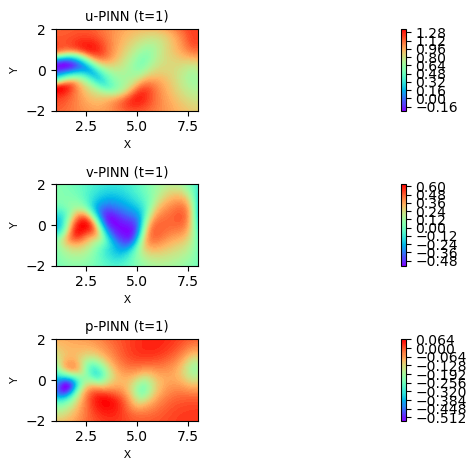

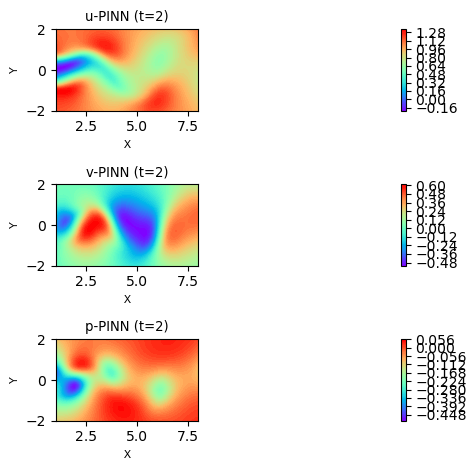

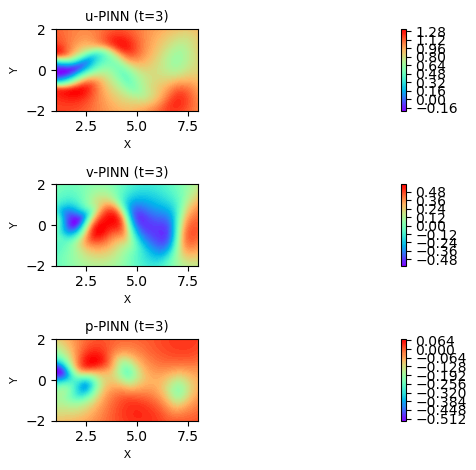

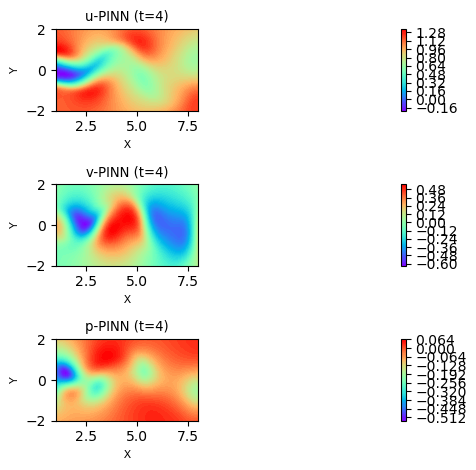

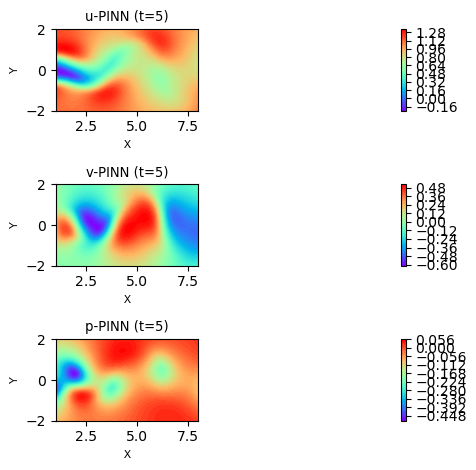

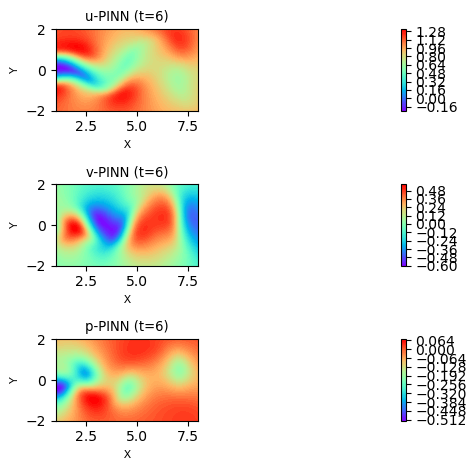

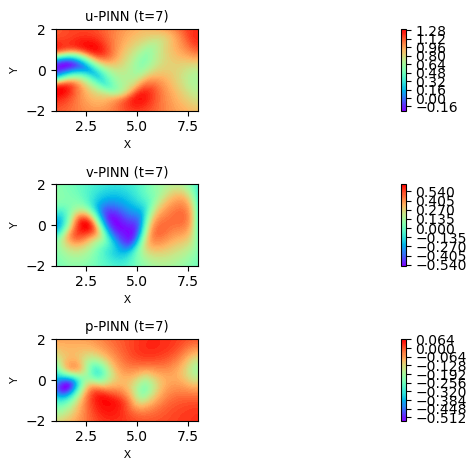

In [15]:
# Plot the velocity and pressure distribution of the flow field:
for t in range(0, 8):
    [ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=140000)
    xyt_pred = np.hstack((ob_x, ob_y, t * np.ones((len(ob_x), 1))))
    uvp_pred = model.predict(xyt_pred)
    x_pred, y_pred, t_pred = xyt_pred[:, 0], xyt_pred[:, 1], xyt_pred[:, 2]
    u_pred, v_pred, p_pred = uvp_pred[:, 0], uvp_pred[:, 1], uvp_pred[:, 2]
    x_true = ob_x[ob_t == t]
    y_true = ob_y[ob_t == t]
    u_true = ob_u[ob_t == t]
    p_true = ob_p[ob_t == t]  # Extract pressure values
    fig, ax = plt.subplots(3, 1)  # Create three subplots
    # Velocity subplot
    cntr0 = ax[0].tricontourf(x_pred, y_pred, u_pred, levels=80, cmap="rainbow")
    cb0 = plt.colorbar(cntr0, ax=ax[0])
    cntr1 = ax[1].tricontourf(x_pred, y_pred, v_pred, levels=80, cmap="rainbow")
    cb1 = plt.colorbar(cntr1, ax=ax[1])
    # Pressure subplot
    cntr2 = ax[2].tricontourf(x_pred, y_pred, p_pred, levels=80, cmap="rainbow")
    cb2 = plt.colorbar(cntr2, ax=ax[2])
    ax[0].set_title("u-PINN " + "(t=" + str(t) + ")", fontsize=9.5)
    ax[1].set_title("v-PINN " + "(t=" + str(t) + ")", fontsize=9.5)
    ax[2].set_title("p-PINN " + "(t=" + str(t) + ")", fontsize=9.5)  # Title for pressure subplot
    for i in range(3):
        ax[i].axis("scaled")
        ax[i].set_xlabel("X", fontsize=7.5, family="Arial")
        ax[i].set_ylabel("Y", fontsize=7.5, family="Arial")
    fig.tight_layout()
    plt.show()